<a href="https://www.kaggle.com/code/rishavnathpati/multiple-cancer-classification-mobilenetv3?scriptVersionId=133783797" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
# These imports are necessary to work with Keras, a high-level deep learning library. 
# It provides modules and functions for defining neural network architectures, preprocessing data, and generating image data for training and validation.
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import cv2
import numpy as np

# The glob module is used for finding file pathnames that match a specific pattern. It is commonly used for data loading and file handling tasks.
from glob import glob

import matplotlib.pyplot as plt

# TensorFlow is a popular open-source deep learning framework. 
# It provides tools and libraries for building and training neural networks. 
# Here, it is imported as tf for working with TensorFlow functionalities.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras import layers

from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random

import cv2
import numpy as np
import requests
from PIL import Image
from io import BytesIO


In [3]:
def initiateGenerator(path):
    base_path = path
    
    # Load the training dataset from the specified directory
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)
    
    # Create an ImageDataGenerator for data augmentation and validation split
    train_datagen = ImageDataGenerator(validation_split=0.2)
    
    # Generate the training data using the ImageDataGenerator
    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training')
    
    # Generate the validation data using the ImageDataGenerator
    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)
    
    # Get the class names and number of classes in the dataset
    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)
    
    # Visualize a sample of the training images with their corresponding labels
    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    
    # Print the shape of a sample image batch
    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
    
    # Return the number of classes, class names, training generator, and validation generator
    return noOfClasses, class_names, train_generator, validation_generator

In [4]:
# The initiateNormalize function performs data normalization on the training dataset using the Rescaling layer from TensorFlow's Keras API. 
# It applies the normalization layer to the training dataset, caches and shuffles the dataset, and prefetches it for improved performance. It also normalizes the pixel values of the images between 0 and 1.
# Finally, it retrieves a batch of normalized images and labels from the dataset, selects the first image from the batch, and prints its minimum and maximum pixel values.
# This function is useful for ensuring that the input images have consistent pixel value ranges, which can help in training the cancer classification model effectively.

def initiateNormalize():
    """
    Preprocesses and normalizes the training and validation datasets.
    
    Returns:
        train_ds (tf.data.Dataset): Normalized training dataset.
        val_ds (tf.data.Dataset): Normalized validation dataset.
    """
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Cache, shuffle, and prefetch the training dataset
    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    
    # Cache and prefetch the validation dataset
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    
    # Create a Rescaling layer to normalize the pixel values between 0 and 1
    normalization_layer = layers.Rescaling(1./255)
    
    # Apply the normalization layer to the training dataset
    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    
    # Get a batch of normalized images and labels
    image_batch, labels_batch = next(iter(normalized_ds))
    
    # Retrieve the first image from the batch and print its minimum and maximum pixel values
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))
    
    return train_ds, val_ds


In [5]:
def initiateModel(noOfClasses):
    """
    Initializes the MobileNetV3 model with pre-trained ImageNet weights for multi-class classification

    Args:
        noOfClasses (int): Number of classes for the classification task.

    Returns:
        tf.keras.Model: Initialized MobileNetV3 model.
    """
    # Initialize the MobileNetV3 model with pre-trained ImageNet weights
    modelInput = tf.keras.applications.MobileNetV3Small(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )

    # Set all the layers in the MobileNetV3 model as non-trainable
    for layer in modelInput.layers:
        layer.trainable = False

    # Flatten the output of the MobileNetV3 model
    x = Flatten()(modelInput.output)

    # Add a fully connected softmax layer for the classification task
    prediction = Dense(noOfClasses, activation='softmax')(x)

    # Create the final model by combining the MobileNetV3 base model and the prediction layer
    model = Model(inputs=modelInput.input, outputs=prediction)

    return model


def modelSummary(model):
    """
    Prints the summary of the model, including the architecture and number of parameters.

    Args:
        model (tf.keras.Model): Model to print the summary of.
    """
    # Print the summary of the model, including the architecture and number of parameters
    model.summary()


In [6]:
# The initiateParams function sets up the parameters for training the cancer classification model. It takes the class name, model, and learning rate as inputs. 
# It creates an Adam optimizer with the specified learning rate, compiles the model with the optimizer, categorical cross-entropy loss function, and accuracy metric.
# It also creates a ReduceLROnPlateau callback, which monitors the validation accuracy. 
# If the validation accuracy plateaus for a certain number of epochs (defined by the patience parameter), the learning rate is reduced by a factor of 0.5. 
# This helps in fine-tuning the model when improvements in accuracy slow down.
# Additionally, it creates a ModelCheckpoint callback, which saves the best model (based on validation accuracy) during training. 
# The saved model will be named using the specified class name followed by 'MobileNet.h5'.
# The function returns the updated model and the annealer and checkpoint callbacks for further use during training.

def initiateParams(className, model, lr):
    """
    Initialize the training parameters and callbacks.

    Parameters:
        className (str): Name of the class.
        model (tf.keras.Model): Model to be compiled.
        lr (float): Learning rate for the optimizer.

    Returns:
        tuple: Model, learning rate reducer callback, and model checkpoint callback.
    """

    # Create an Adam optimizer with the specified learning rate
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    # Compile the model with the optimizer, loss function, and evaluation metric
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Create a ReduceLROnPlateau callback to reduce the learning rate when validation accuracy plateaus
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)

    # Create a ModelCheckpoint callback to save the best model during training
    checkpoint = ModelCheckpoint(className + 'MobileNet.h5', verbose=1, save_best_only=True)

    # Return the model and the callbacks
    return model, annealer, checkpoint



In [7]:
def modelFit(model, annealer, checkpoint, epochs=20, batchSize=256):
    """
    Function to train the model.

    Args:
        model (tf.keras.Model): The model to be trained.
        annealer (tf.keras.callbacks.LearningRateScheduler): Learning rate scheduler callback.
        checkpoint (tf.keras.callbacks.ModelCheckpoint): Model checkpoint callback.
        epochs (int): Number of training epochs. Default is 20.
        batchSize (int): Batch size for training. Default is 256.

    Returns:
        history (tf.keras.callbacks.History): Training history.

    """
    # Fit the model to the training data
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        batch_size=batchSize,
        callbacks=[annealer, checkpoint],
        steps_per_epoch=len(train_generator),
        validation_steps=len(validation_generator)
    )

    return history


In [8]:
def plotOutput(history, className, epochs):
    
    """
    Plot the training and validation accuracy, and training and validation loss over epochs.
    
    Args:
        history: A history object containing the training history.
        className: Name of the class or model being trained.
        epochs: Total number of epochs.

    Returns:
        None
    """
    
    # Retrieve the training and validation accuracy values from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Retrieve the training and validation loss values from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create an array of epochs
    epochs_range = range(epochs)

    # Create a figure with subplots for accuracy and loss
    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    
    # Plot the training and validation accuracy
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    
    # Plot the training and validation loss
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    # Show the plot
    plt.show()
    
    # Save the plot as an image file
    plt.savefig(className + '_graph.png')


In [9]:
def evalModel(model):
    """
    Evaluate the model on the validation data generator and print the accuracy.

    Args:
        model (tf.keras.Model): The trained model to evaluate.

    Returns:
        None
    """
    
    # Evaluate the model on the validation data generator
    evl = model.evaluate(validation_generator)
    
    # Retrieve the accuracy from the evaluation results
    acc = evl[1] * 100
    
    # Format the accuracy message
    msg = f'Accuracy on the Test Set = {acc:5.2f} %'
    
    # Print the accuracy message
    print(msg)

def saveModel(model, className):
    # Save the model as an h5 file with the specified class name
    model.save(className + " - MobileNetV3.h5")
    
    # Print a confirmation message
    print("Model Saved!")


In [10]:
# The plot_confusion_matrix function plots the confusion matrix based on the provided values. 
# It takes the confusion matrix cm, target class names target_names, plot title title, colormap cmap, and normalization flag normalize as inputs.
# The function calculates the accuracy and misclassification rate based on the confusion matrix. 
# It creates a figure, plots the confusion matrix as an image with a color bar, and sets the axis ticks and labels based on the target class names if provided.
# If normalization is enabled, the confusion matrix is normalized. The function then determines the threshold for text color based on the normalization and iterates over the matrix to add text annotations.
# Finally, the function sets the labels, title, and displays the plot. It also saves the plot as an image file with the specified title.
# This function can be used to visualize and analyze the performance of a classification model using a confusion matrix.

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    # Import required libraries
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    # Calculate accuracy and misclassification rate
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    # Set colormap if not provided
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    # Create a figure and plot the confusion matrix
    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Set axis ticks and labels if target names are provided
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    # Normalize the confusion matrix if specified
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Determine the threshold for text color based on normalization
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    # Iterate over the confusion matrix and add text annotations
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    # Set labels, title, and display the plot
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    # Save the plot as an image file
    plt.savefig(title + '.png')

In [11]:
# The callPlot function takes the model, class name, and class names list as inputs. It first retrieves the true labels from the validation data generator and prints them. T
# hen, it uses the model to predict labels for the validation data generator and prints the predicted labels. Next, it calculates the confusion matrix based on the true and predicted labels.
# Finally, the function calls the plot_confusion_matrix function with the calculated confusion matrix, disabling normalization, providing the target class names list, and specifying the title as className + "Confusion Matrix". 
# The plot_confusion_matrix function is responsible for plotting the confusion matrix.
# This function can be used to evaluate the performance of a classification model by generating a confusion matrix and visualizing it using the plot_confusion_matrix function.

def callPlot(model, className, classes):
    """
    Generates and plots the confusion matrix for evaluating the performance of a classification model.
    
    Args:
        model: The trained classification model.
        className: The name of the class for which the confusion matrix is generated.
        classes: The list of class names.
    """
    # Get the true labels from the validation data generator
    y_true = validation_generator.classes
    print("True : ", (y_true))

    # Predict the labels using the model and the validation data generator
    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    # Calculate the confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)

    # Call the plot_confusion_matrix function to plot the confusion matrix
    plot_confusion_matrix(cm=conf_mat,
                          normalize=False,
                          target_names=classes,
                          title=className + " Confusion Matrix")

In [12]:
def load_image(image_path_or_url):
    if image_path_or_url.startswith('http'):
        # Load image from URL
        response = requests.get(image_path_or_url)
        image = Image.open(BytesIO(response.content))
    else:
        # Load image from local file path
        image = Image.open(image_path_or_url)
    return image

def preprocess_image(image):
    image = image.resize((224, 224))
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = np.expand_dims(image, axis=0)
    return image

def predict_cancer_type(image_path_or_url):
    # Load the image
    image = load_image(image_path_or_url)

    # Preprocess the image
    image = preprocess_image(image)

    # Make predictions
    predictions = model.predict(image)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]

    # Load the image for visualization
    image_for_display = cv2.cvtColor(cv2.imread(image_path_or_url), cv2.COLOR_BGR2RGB)

    # Get the probability score for the predicted class
    predicted_prob = predictions[0][predicted_class_index]

    # Prepare the text to be displayed on the image
    text = f"Predicted: {predicted_class}\nProbability: {predicted_prob:5.3f}"

    # Resize the image and create a blank canvas for the enlarged image
    enlarged_image = cv2.resize(image_for_display, (800, 800))
    canvas = np.ones_like(enlarged_image) * 255

    # Calculate the position for the text on the canvas
    text_position = (20, 40)

    # Paste the enlarged image onto the canvas
    canvas[:enlarged_image.shape[0], :enlarged_image.shape[1], :] = enlarged_image

    # Display the image with the predicted class and probability
    plt.imshow(canvas)
    plt.title("Cancer Type Prediction")
    plt.text(*text_position, text, fontsize=16, color='black', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
    plt.axis("off")
    plt.show()

    return predicted_class

In [4]:
mpath = r'../input/multi-cancer/Multi Cancer'
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 10
lr = 0.001

classPaths.sort()  # Sort the class paths alphabetically

for className in classPaths:
    print(className)

ALL
Brain Cancer
Breast Cancer
Cervical Cancer
Kidney Cancer
Lung and Colon Cancer
Lymphoma
Oral Cancer


# Acute Lymphoblastic Leukemia


Total :  Found 20000 files belonging to 4 classes.

For Training :  Found 16000 images belonging to 4 classes.

For Val :  Found 4000 images belonging to 4 classes.

No of Classes :  4
Classes :  ['all_benign', 'all_early', 'all_pre', 'all_pro']
Image Shape :  (32, 256, 256, 3)
6709248/6698480 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112,

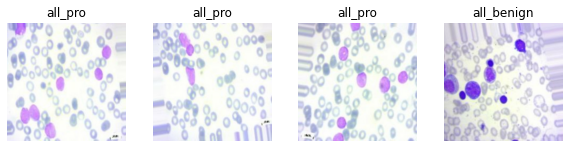

In [14]:
className='ALL'

cpath = os.path.join(mpath, className)

# Initiate the generator
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)

# Initiate the model
curModel = initiateModel(noOfClasses)

# Print the model summary
modelSummary(curModel)

# Initiate model parameters and callbacks
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)

Epoch 1/10
500/500 [==============================] - 239s 448ms/step - loss: 0.1821 - accuracy: 0.9535 - val_loss: 0.0632 - val_accuracy: 0.9868

Epoch 00001: val_loss improved from inf to 0.06320, saving model to ALLMobileNet.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
500/500 [==============================] - 116s 233ms/step - loss: 0.0501 - accuracy: 0.9896 - val_loss: 0.0358 - val_accuracy: 0.9933

Epoch 00002: val_loss improved from 0.06320 to 0.03579, saving model to ALLMobileNet.h5
Epoch 3/10
500/500 [==============================] - 113s 226ms/step - loss: 0.0326 - accuracy: 0.9931 - val_loss: 0.0265 - val_accuracy: 0.9952

Epoch 00003: val_loss improved from 0.03579 to 0.02654, saving model to ALLMobileNet.h5
Epoch 4/10
500/500 [==============================] - 112s 225ms/step - loss: 0.0239 - accuracy: 0.9956 - val_loss: 0.0216 - val_accuracy: 0.9950

Epoch 00004: val_loss improved from 0.02654 to 0.02162, saving model to ALLMobileNet.h5
Epoch 5/10
500/500 [==============================] - 111s 222ms/step - loss: 0.0191 - accuracy: 0.9959 - val_loss: 0.0170 - val_accuracy: 0.9958

Epoch 00005: val_loss improved from 0.02162 to 0.01700, saving model to ALLMobileNet.h5
Epoch 6/10
500/500 [==============================] - 114s 2

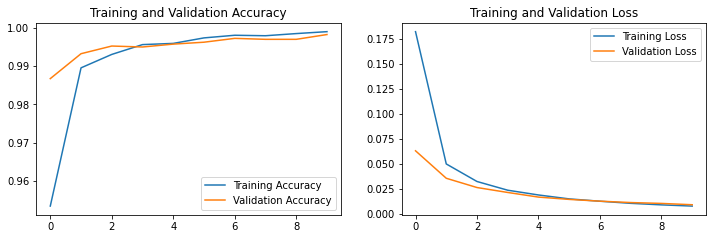

125/125 [==============================] - 22s 177ms/step - loss: 0.0094 - accuracy: 0.9983
Accuracy on the Test Set = 99.83 %
Model Saved!
True :  [0 0 0 ... 3 3 3]
Predicted :  [0 0 0 ... 3 3 3]


<Figure size 432x288 with 0 Axes>

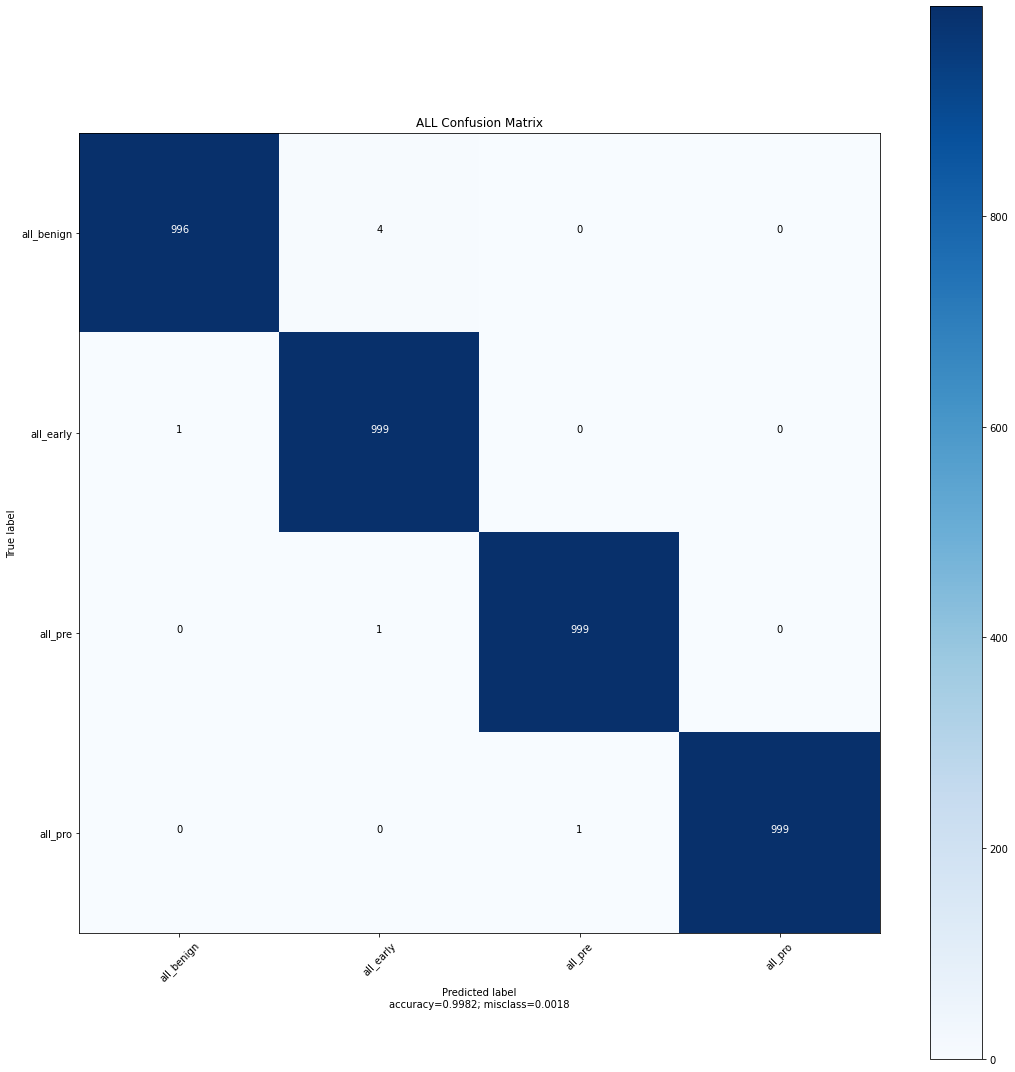

<Figure size 432x288 with 0 Axes>

In [31]:
# Train the model
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)

# Plot training history
plotOutput(curHistory, className, gEpochs)

# Evaluate the model
evalModel(curModel)

# Save the model
saveModel(curModel, className)

# Plot the confusion matrix
callPlot(curModel, className, class_names)

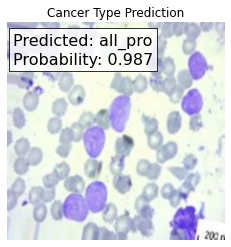

Predicted Cancer Type: all_pro


In [17]:
# Load the trained model
model = tf.keras.models.load_model(className+"MobileNet.h5")

# Provide the path to the input image
input_image_path = "/kaggle/input/multi-cancer/Multi Cancer/ALL/all_early/all_early_0002.jpg"
predicted_cancer_type = predict_cancer_type(input_image_path)

# Print the predicted cancer type
print("Predicted Cancer Type:", predicted_cancer_type)


*****************

# Brain Cancer

In [1]:
className='Brain Cancer'

cpath = os.path.join(mpath, className)

# Initiate the generator
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)

# Initiate the model
curModel = initiateModel(noOfClasses)

# Print the model summary
modelSummary(curModel)

# Initiate model parameters and callbacks
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)

NameError: name 'os' is not defined

Epoch 1/10
375/375 [==============================] - 149s 391ms/step - loss: 0.3221 - accuracy: 0.8866 - val_loss: 0.2049 - val_accuracy: 0.9300

Epoch 00001: val_loss improved from inf to 0.20486, saving model to Brain CancerMobileNet.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
375/375 [==============================] - 80s 214ms/step - loss: 0.1775 - accuracy: 0.9436 - val_loss: 0.1593 - val_accuracy: 0.9443

Epoch 00002: val_loss improved from 0.20486 to 0.15929, saving model to Brain CancerMobileNet.h5
Epoch 3/10
375/375 [==============================] - 79s 211ms/step - loss: 0.1442 - accuracy: 0.9533 - val_loss: 0.1386 - val_accuracy: 0.9497

Epoch 00003: val_loss improved from 0.15929 to 0.13859, saving model to Brain CancerMobileNet.h5
Epoch 4/10
375/375 [==============================] - 81s 217ms/step - loss: 0.1235 - accuracy: 0.9607 - val_loss: 0.1228 - val_accuracy: 0.9573

Epoch 00004: val_loss improved from 0.13859 to 0.12279, saving model to Brain CancerMobileNet.h5
Epoch 5/10
375/375 [==============================] - 81s 215ms/step - loss: 0.1089 - accuracy: 0.9677 - val_loss: 0.1148 - val_accuracy: 0.9593

Epoch 00005: val_loss improved from 0.12279 to 0.11478, saving model to Brain CancerMobileNet.h5
Epoch 6/10
375/375 [========

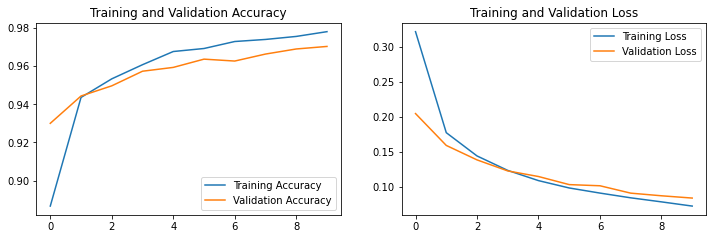

94/94 [==============================] - 17s 178ms/step - loss: 0.0840 - accuracy: 0.9703
Accuracy on the Test Set = 97.03 %
Model Saved!
True :  [0 0 0 ... 2 2 2]
Predicted :  [0 0 0 ... 2 2 2]


<Figure size 432x288 with 0 Axes>

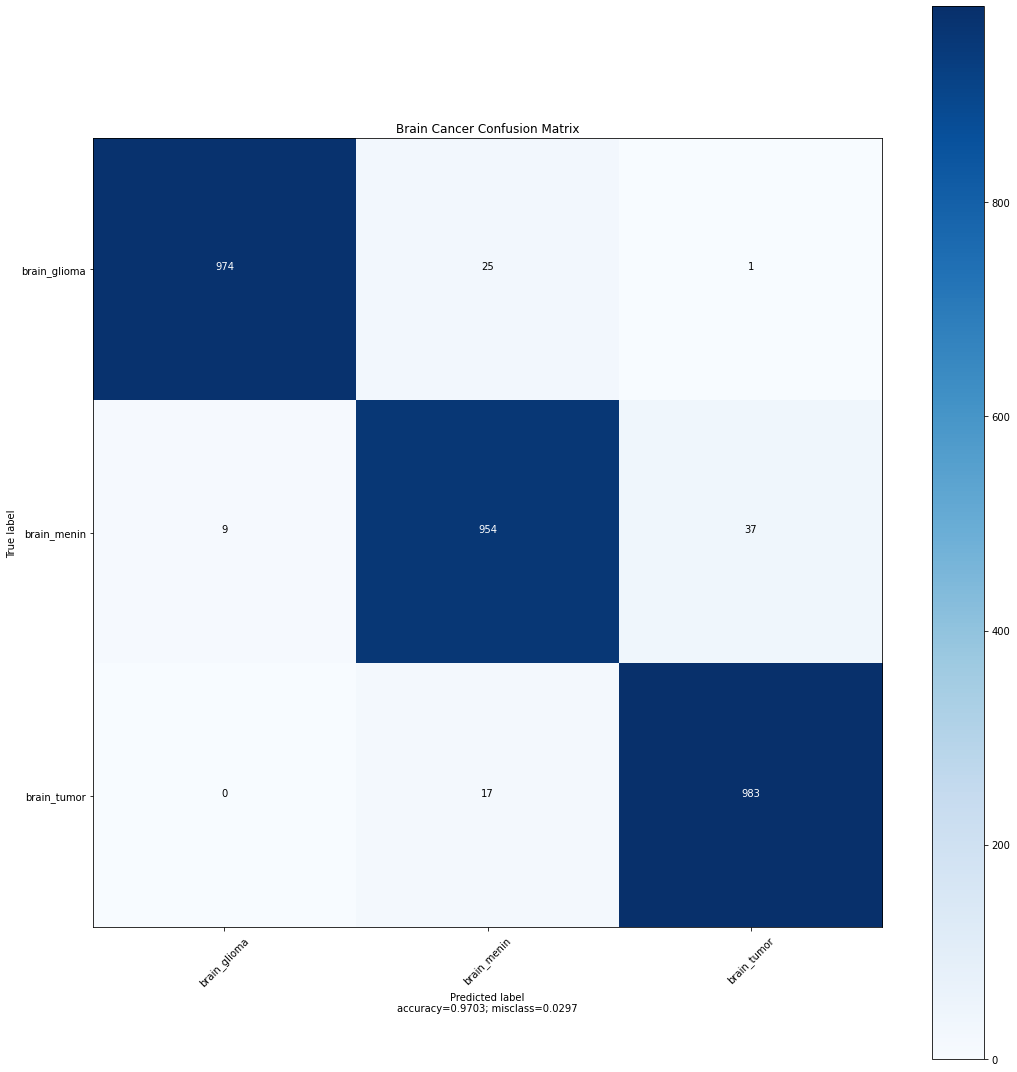

<Figure size 432x288 with 0 Axes>

In [38]:
# Train the model
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize = 256)

# Plot training history
plotOutput(curHistory, className, gEpochs)

# Evaluate the model
evalModel(curModel)

# Save the model
saveModel(curModel, className)

# Plot the confusion matrix
callPlot(curModel, className, class_names)

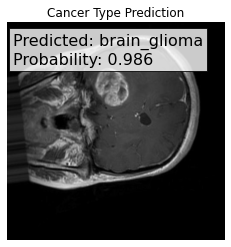

Predicted Cancer Type: brain_glioma


In [24]:
# Load the trained model
model = tf.keras.models.load_model(className+" - MobileNetV3.h5")

# Provide the path to the input image
input_image_path = "/kaggle/input/multi-cancer/Multi Cancer/Brain Cancer/brain_glioma/brain_glioma_0002.jpg"
predicted_cancer_type = predict_cancer_type(input_image_path)

# Print the predicted cancer type
print("Predicted Cancer Type:", predicted_cancer_type)

******************* 

# Breast Cancer

In [ ]:
className='Breast Cancer'

cpath = os.path.join(mpath, className)

# Initiate the generator
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)

# Initiate the model
curModel = initiateModel(noOfClasses)

# Print the model summary
modelSummary(curModel)

# Initiate model parameters and callbacks
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)

Epoch 1/10
250/250 [==============================] - 169s 664ms/step - loss: 0.0998 - accuracy: 0.9656 - val_loss: 0.0669 - val_accuracy: 0.9785

Epoch 00001: val_loss improved from inf to 0.06685, saving model to Breast CancerMobileNet.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
250/250 [==============================] - 93s 372ms/step - loss: 0.0382 - accuracy: 0.9908 - val_loss: 0.0667 - val_accuracy: 0.9760

Epoch 00002: val_loss improved from 0.06685 to 0.06671, saving model to Breast CancerMobileNet.h5
Epoch 3/10
250/250 [==============================] - 93s 373ms/step - loss: 0.0282 - accuracy: 0.9926 - val_loss: 0.0534 - val_accuracy: 0.9820

Epoch 00003: val_loss improved from 0.06671 to 0.05343, saving model to Breast CancerMobileNet.h5
Epoch 4/10
250/250 [==============================] - 93s 373ms/step - loss: 0.0232 - accuracy: 0.9935 - val_loss: 0.0575 - val_accuracy: 0.9780

Epoch 00004: val_loss did not improve from 0.05343
Epoch 5/10
250/250 [==============================] - 93s 373ms/step - loss: 0.0199 - accuracy: 0.9948 - val_loss: 0.0532 - val_accuracy: 0.9800

Epoch 00005: val_loss improved from 0.05343 to 0.05320, saving model to Breast CancerMobileNet.h5
Epoch 6/10
250/250 [==============================] - 93s 372ms/step - 

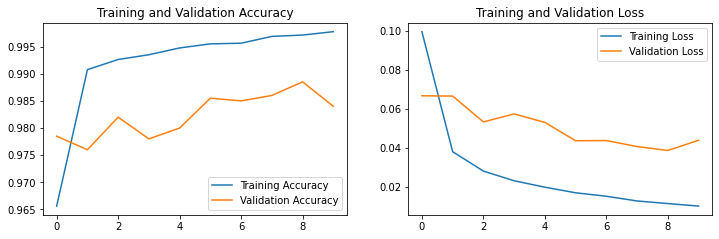

63/63 [==============================] - 19s 302ms/step - loss: 0.0440 - accuracy: 0.9840
Accuracy on the Test Set = 98.40 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

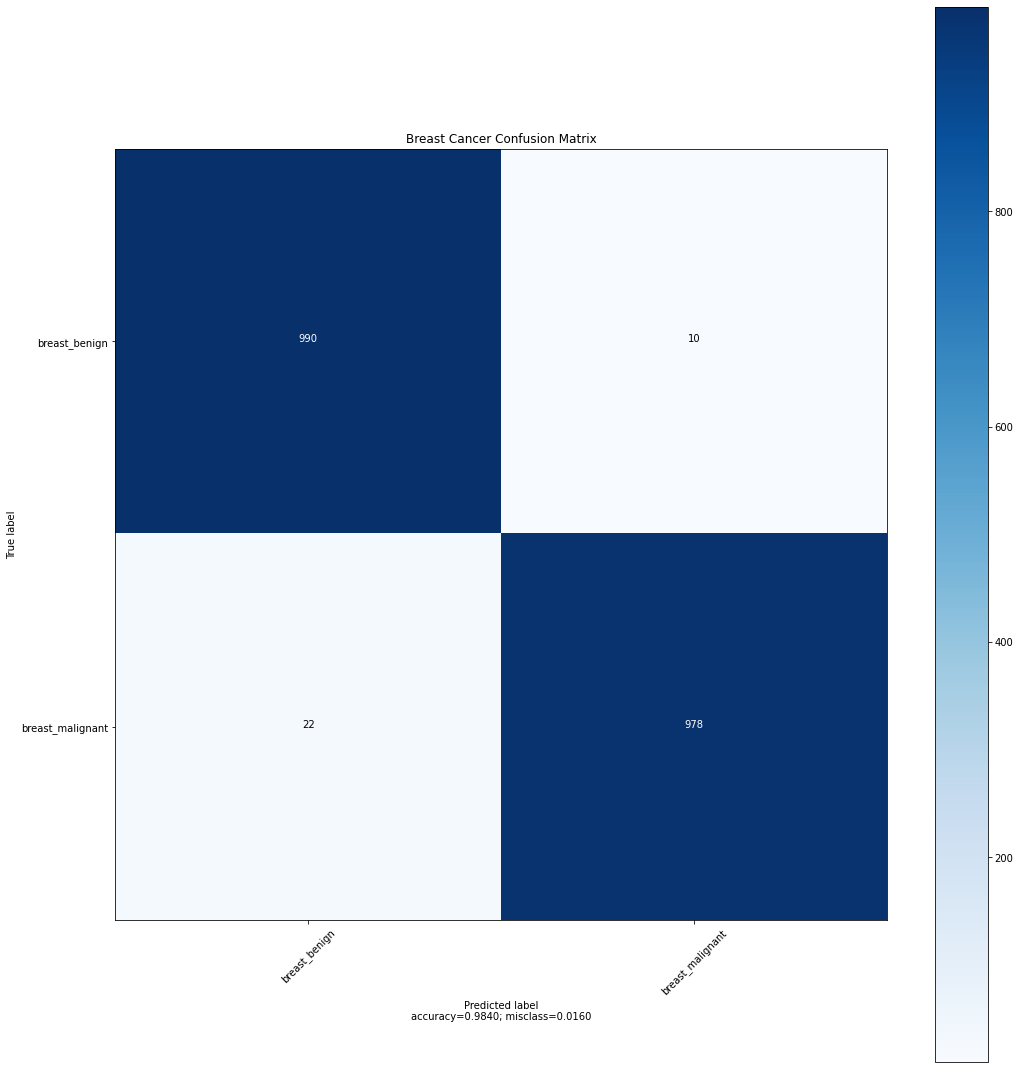

<Figure size 432x288 with 0 Axes>

In [41]:
# Train the model
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize = 256)

# Plot training history
plotOutput(curHistory, className, gEpochs)

# Evaluate the model
evalModel(curModel)

# Save the model
saveModel(curModel, className)

# Plot the confusion matrix
callPlot(curModel, className, class_names)

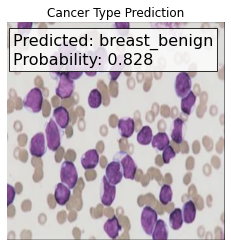

Predicted Cancer Type: breast_benign


In [42]:
# Load the trained model
model = tf.keras.models.load_model(className+" - MobileNetV3.h5")

# Provide the path to the input image
input_image_path = "/kaggle/input/cancer-test-dataset/Screenshot 2023-06-16 at 12.04.09AM.png"
predicted_cancer_type = predict_cancer_type(input_image_path)

# Print the predicted cancer type
print("Predicted Cancer Type:", predicted_cancer_type)

***************

# Cervical Cancer


Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 20000 images belonging to 5 classes.

For Val :  Found 5000 images belonging to 5 classes.

No of Classes :  5
Classes :  ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
Image Shape :  (32, 256, 256, 3)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 224, 224, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_3[0][0]      

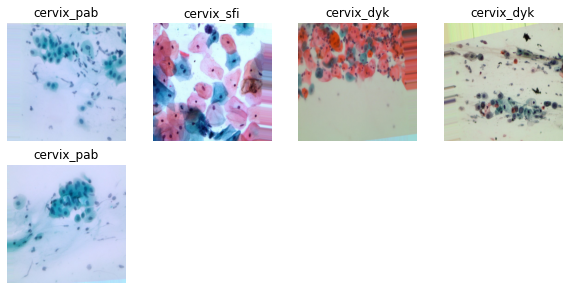

In [43]:
className='Cervical Cancer'

cpath = os.path.join(mpath, className)

# Initiate the generator
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)

# Initiate the model
curModel = initiateModel(noOfClasses)

# Print the model summary
modelSummary(curModel)

# Initiate model parameters and callbacks
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)


Epoch 1/10
625/625 [==============================] - 271s 428ms/step - loss: 0.3387 - accuracy: 0.8924 - val_loss: 0.1603 - val_accuracy: 0.9594

Epoch 00001: val_loss improved from inf to 0.16031, saving model to Cervical CancerMobileNet.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
625/625 [==============================] - 147s 236ms/step - loss: 0.1290 - accuracy: 0.9644 - val_loss: 0.1019 - val_accuracy: 0.9744

Epoch 00002: val_loss improved from 0.16031 to 0.10187, saving model to Cervical CancerMobileNet.h5
Epoch 3/10
625/625 [==============================] - 154s 246ms/step - loss: 0.0850 - accuracy: 0.9786 - val_loss: 0.0780 - val_accuracy: 0.9790

Epoch 00003: val_loss improved from 0.10187 to 0.07798, saving model to Cervical CancerMobileNet.h5
Epoch 4/10
625/625 [==============================] - 155s 248ms/step - loss: 0.0637 - accuracy: 0.9848 - val_loss: 0.0601 - val_accuracy: 0.9868

Epoch 00004: val_loss improved from 0.07798 to 0.06006, saving model to Cervical CancerMobileNet.h5
Epoch 5/10
625/625 [==============================] - 154s 246ms/step - loss: 0.0503 - accuracy: 0.9887 - val_loss: 0.0502 - val_accuracy: 0.9880

Epoch 00005: val_loss improved from 0.06006 to 0.05019, saving model to Cervical CancerMobileNet.h5
Epoch 6/10
6

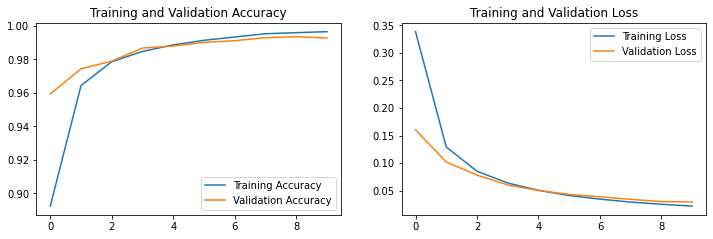

157/157 [==============================] - 31s 195ms/step - loss: 0.0293 - accuracy: 0.9928
Accuracy on the Test Set = 99.28 %
Model Saved!
True :  [0 0 0 ... 4 4 4]
Predicted :  [0 0 0 ... 4 4 4]


<Figure size 432x288 with 0 Axes>

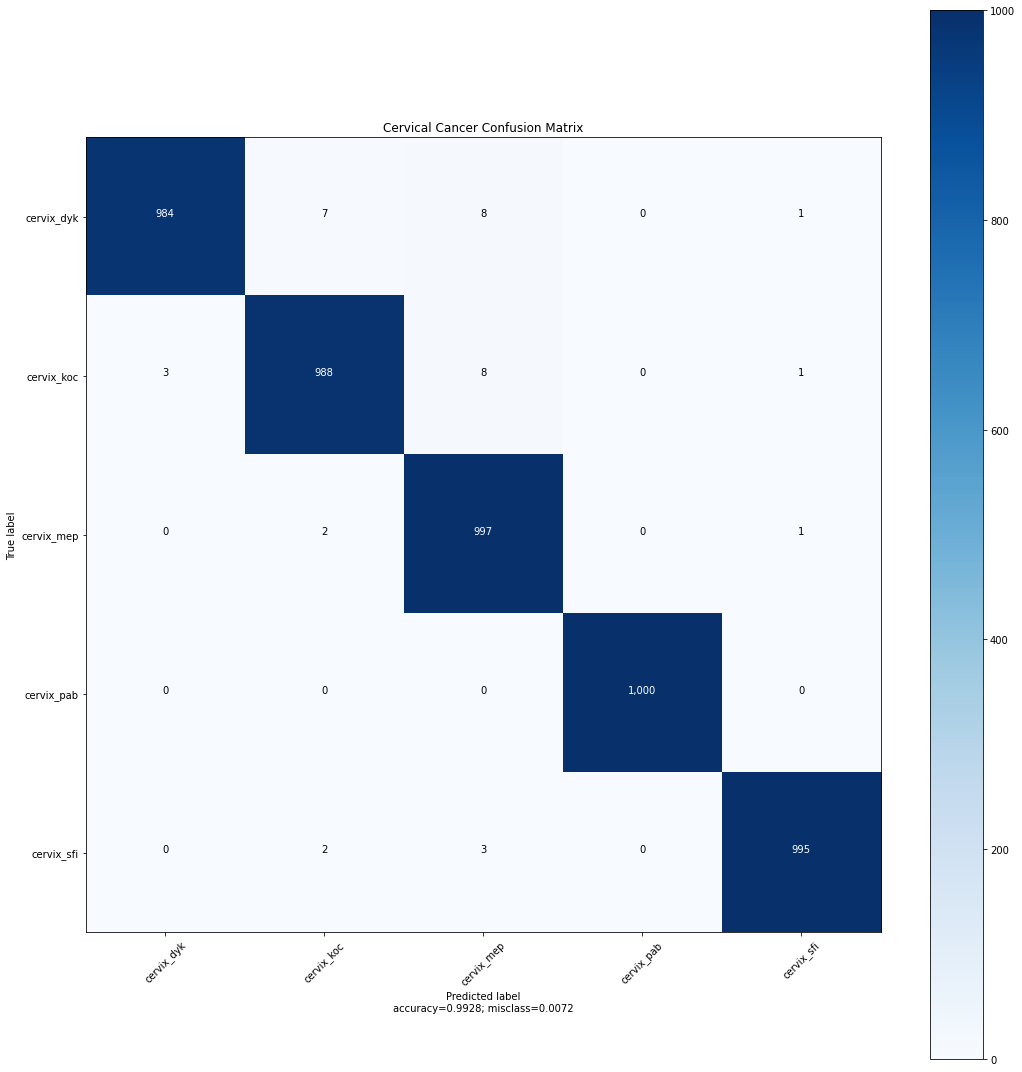

<Figure size 432x288 with 0 Axes>

In [44]:
# Train the model
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize = 256)

# Plot training history
plotOutput(curHistory, className, gEpochs)

# Evaluate the model
evalModel(curModel)

# Save the model
saveModel(curModel, className)

# Plot the confusion matrix
callPlot(curModel, className, class_names)

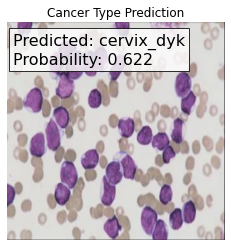

Predicted Cancer Type: cervix_dyk


In [45]:
# Load the trained model
model = tf.keras.models.load_model(className+" - MobileNetV3.h5")

# Provide the path to the input image
input_image_path = "/kaggle/input/cancer-test-dataset/Screenshot 2023-06-16 at 12.04.09AM.png"
predicted_cancer_type = predict_cancer_type(input_image_path)

# Print the predicted cancer type
print("Predicted Cancer Type:", predicted_cancer_type)

***************

# Kidney Cancer


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 8000 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['kidney_normal', 'kidney_tumor']
Image Shape :  (32, 256, 256, 3)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_4[0][0]                
___________________________

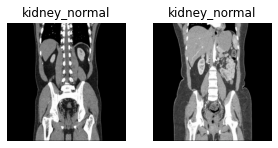

In [46]:
className='Kidney Cancer'

cpath = os.path.join(mpath, className)

# Initiate the generator
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)

# Initiate the model
curModel = initiateModel(noOfClasses)

# Print the model summary
modelSummary(curModel)

# Initiate model parameters and callbacks
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)

Epoch 1/10
250/250 [==============================] - 115s 445ms/step - loss: 0.2158 - accuracy: 0.9311 - val_loss: 0.1524 - val_accuracy: 0.9535

Epoch 00001: val_loss improved from inf to 0.15243, saving model to Kidney CancerMobileNet.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
250/250 [==============================] - 57s 229ms/step - loss: 0.0667 - accuracy: 0.9925 - val_loss: 0.1371 - val_accuracy: 0.9480

Epoch 00002: val_loss improved from 0.15243 to 0.13713, saving model to Kidney CancerMobileNet.h5
Epoch 3/10
250/250 [==============================] - 58s 232ms/step - loss: 0.0390 - accuracy: 0.9975 - val_loss: 0.1141 - val_accuracy: 0.9530

Epoch 00003: val_loss improved from 0.13713 to 0.11414, saving model to Kidney CancerMobileNet.h5
Epoch 4/10
250/250 [==============================] - 58s 230ms/step - loss: 0.0264 - accuracy: 0.9989 - val_loss: 0.1152 - val_accuracy: 0.9515

Epoch 00004: val_loss did not improve from 0.11414
Epoch 5/10
250/250 [==============================] - 57s 228ms/step - loss: 0.0192 - accuracy: 0.9990 - val_loss: 0.1126 - val_accuracy: 0.9535

Epoch 00005: val_loss improved from 0.11414 to 0.11257, saving model to Kidney CancerMobileNet.h5
Epoch 6/10
250/250 [==============================] - 57s 227ms/step - 

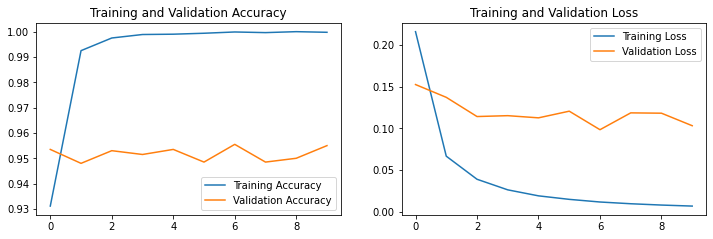

63/63 [==============================] - 12s 185ms/step - loss: 0.1031 - accuracy: 0.9550
Accuracy on the Test Set = 95.50 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

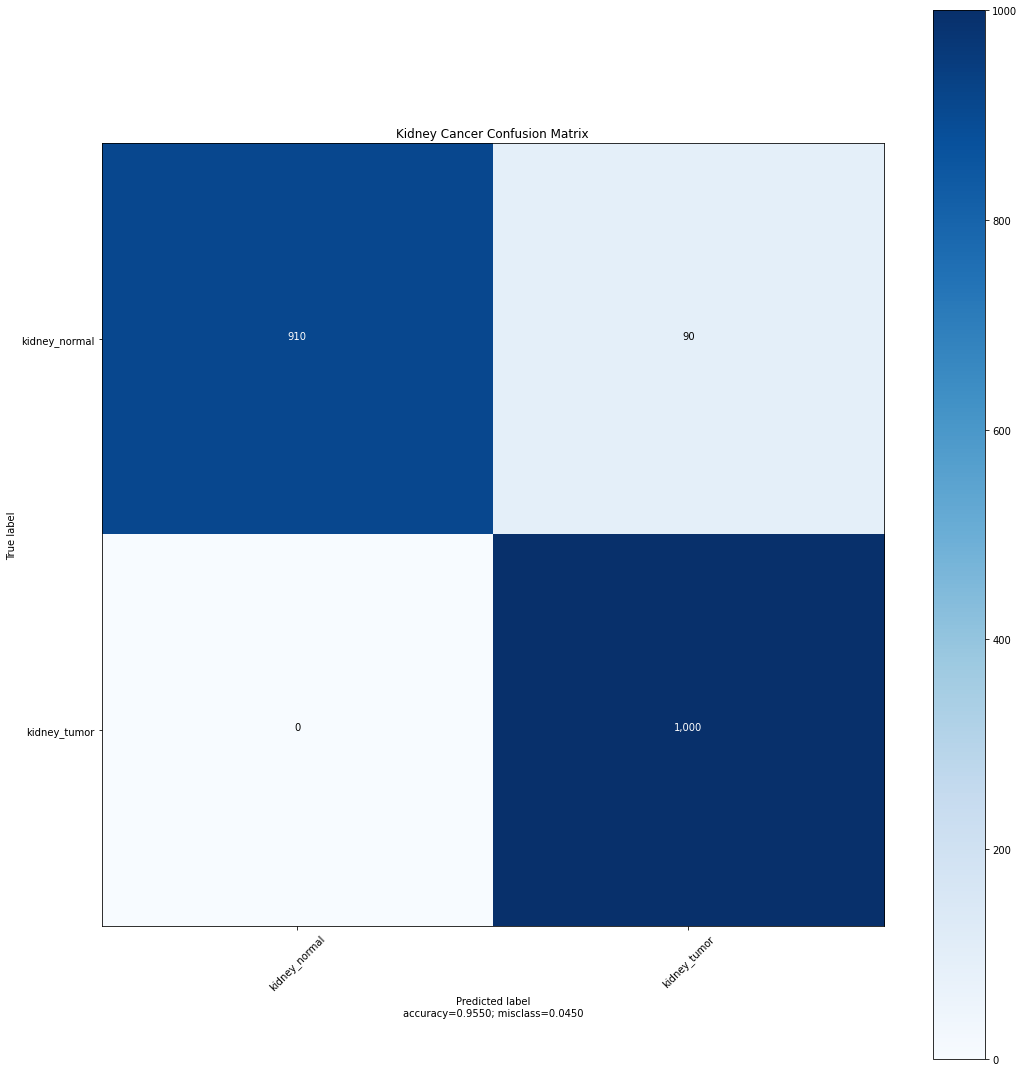

<Figure size 432x288 with 0 Axes>

In [47]:
# Train the model
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize = 256)

# Plot training history
plotOutput(curHistory, className, gEpochs)

# Evaluate the model
evalModel(curModel)

# Save the model
saveModel(curModel, className)

# Plot the confusion matrix
callPlot(curModel, className, class_names)

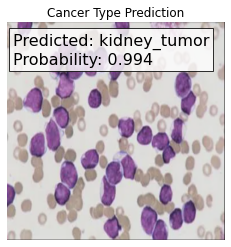

Predicted Cancer Type: kidney_tumor


In [48]:
# Load the trained model
model = tf.keras.models.load_model(className+" - MobileNetV3.h5")

# Provide the path to the input image
input_image_path = "/kaggle/input/cancer-test-dataset/Screenshot 2023-06-16 at 12.04.09AM.png"
predicted_cancer_type = predict_cancer_type(input_image_path)

# Print the predicted cancer type
print("Predicted Cancer Type:", predicted_cancer_type)

*************

# Lung and Colon Cancer

In [5]:
className='Lung and Colon Cancer'

cpath = os.path.join(mpath, className)

# Initiate the generator
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)

# Initiate the model
curModel = initiateModel(noOfClasses)

# Print the model summary
modelSummary(curModel)

# Initiate model parameters and callbacks
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)

NameError: name 'initiateGenerator' is not defined

Epoch 1/10
625/625 [==============================] - 304s 481ms/step - loss: 0.1517 - accuracy: 0.9554 - val_loss: 0.0698 - val_accuracy: 0.9780

Epoch 00001: val_loss improved from inf to 0.06980, saving model to Lung and Colon CancerMobileNet.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
625/625 [==============================] - 156s 249ms/step - loss: 0.0561 - accuracy: 0.9808 - val_loss: 0.0533 - val_accuracy: 0.9798

Epoch 00002: val_loss improved from 0.06980 to 0.05334, saving model to Lung and Colon CancerMobileNet.h5
Epoch 3/10
625/625 [==============================] - 156s 250ms/step - loss: 0.0407 - accuracy: 0.9860 - val_loss: 0.0411 - val_accuracy: 0.9886

Epoch 00003: val_loss improved from 0.05334 to 0.04109, saving model to Lung and Colon CancerMobileNet.h5
Epoch 4/10
625/625 [==============================] - 156s 250ms/step - loss: 0.0325 - accuracy: 0.9900 - val_loss: 0.0328 - val_accuracy: 0.9900

Epoch 00004: val_loss improved from 0.04109 to 0.03285, saving model to Lung and Colon CancerMobileNet.h5
Epoch 5/10
625/625 [==============================] - 156s 250ms/step - loss: 0.0261 - accuracy: 0.9923 - val_loss: 0.0277 - val_accuracy: 0.9920

Epoch 00005: val_loss improved from 0.03285 to 0.02769, saving model to Lung and Colon CancerM

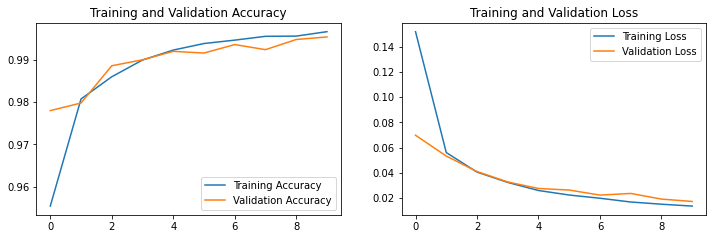

157/157 [==============================] - 31s 198ms/step - loss: 0.0174 - accuracy: 0.9954
Accuracy on the Test Set = 99.54 %
Model Saved!
True :  [0 0 0 ... 4 4 4]
Predicted :  [0 1 0 ... 4 4 4]


<Figure size 432x288 with 0 Axes>

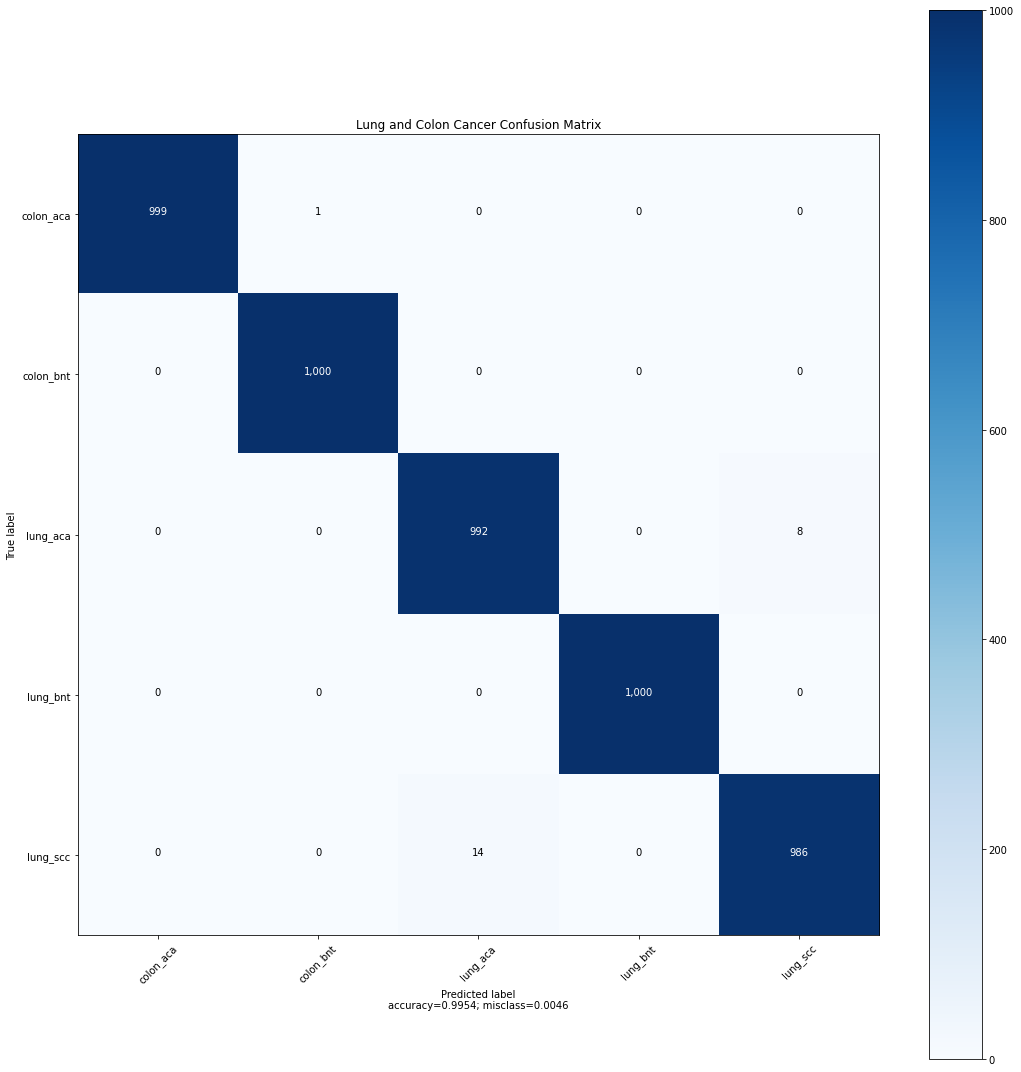

<Figure size 432x288 with 0 Axes>

In [50]:
# Train the model
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize = 256)

# Plot training history
plotOutput(curHistory, className, gEpochs)

# Evaluate the model
evalModel(curModel)

# Save the model
saveModel(curModel, className)

# Plot the confusion matrix
callPlot(curModel, className, class_names)

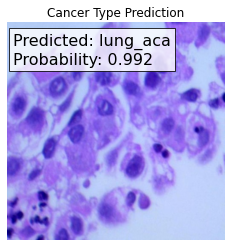

Predicted Cancer Type: lung_aca


In [26]:
# Load the trained model
model = tf.keras.models.load_model(className+" - MobileNetV3.h5")

# Provide the path to the input image
input_image_path = "/kaggle/input/multi-cancer/Multi Cancer/Lung and Colon Cancer/lung_aca/lung_aca_0005.jpg"
predicted_cancer_type = predict_cancer_type(input_image_path)

# Print the predicted cancer type
print("Predicted Cancer Type:", predicted_cancer_type)

*************

# Lymphoma


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 12000 images belonging to 3 classes.

For Val :  Found 3000 images belonging to 3 classes.

No of Classes :  3
Classes :  ['lymph_cll', 'lymph_fl', 'lymph_mcl']
Image Shape :  (32, 256, 256, 3)
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_6 (Rescaling)         (None, 224, 224, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_6[0][0]                
_____________________

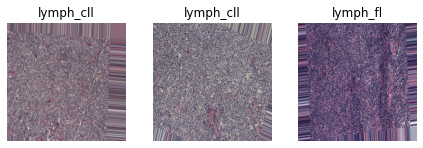

In [52]:
className='Lymphoma'

cpath = os.path.join(mpath, className)

# Initiate the generator
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)

# Initiate the model
curModel = initiateModel(noOfClasses)

# Print the model summary
modelSummary(curModel)

# Initiate model parameters and callbacks
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)

Epoch 1/10
375/375 [==============================] - 198s 518ms/step - loss: 0.7399 - accuracy: 0.6735 - val_loss: 0.6194 - val_accuracy: 0.7487

Epoch 00001: val_loss improved from inf to 0.61942, saving model to LymphomaMobileNet.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
375/375 [==============================] - 106s 283ms/step - loss: 0.5592 - accuracy: 0.7715 - val_loss: 0.5295 - val_accuracy: 0.7917

Epoch 00002: val_loss improved from 0.61942 to 0.52951, saving model to LymphomaMobileNet.h5
Epoch 3/10
375/375 [==============================] - 106s 284ms/step - loss: 0.4977 - accuracy: 0.8046 - val_loss: 0.4885 - val_accuracy: 0.8070

Epoch 00003: val_loss improved from 0.52951 to 0.48848, saving model to LymphomaMobileNet.h5
Epoch 4/10
375/375 [==============================] - 106s 282ms/step - loss: 0.4582 - accuracy: 0.8235 - val_loss: 0.4644 - val_accuracy: 0.8187

Epoch 00004: val_loss improved from 0.48848 to 0.46436, saving model to LymphomaMobileNet.h5
Epoch 5/10
375/375 [==============================] - 106s 283ms/step - loss: 0.4316 - accuracy: 0.8320 - val_loss: 0.4448 - val_accuracy: 0.8227

Epoch 00005: val_loss improved from 0.46436 to 0.44477, saving model to LymphomaMobileNet.h5
Epoch 6/10
375/375 [====================

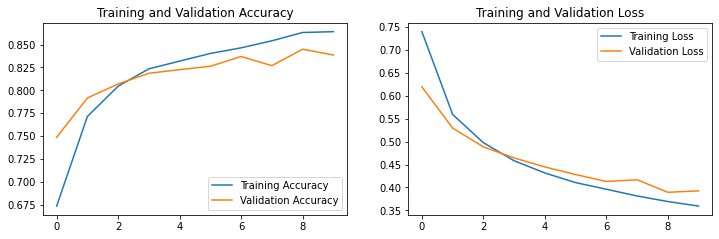

94/94 [==============================] - 21s 225ms/step - loss: 0.3925 - accuracy: 0.8387
Accuracy on the Test Set = 83.87 %
Model Saved!
True :  [0 0 0 ... 2 2 2]
Predicted :  [0 0 0 ... 2 2 2]


<Figure size 432x288 with 0 Axes>

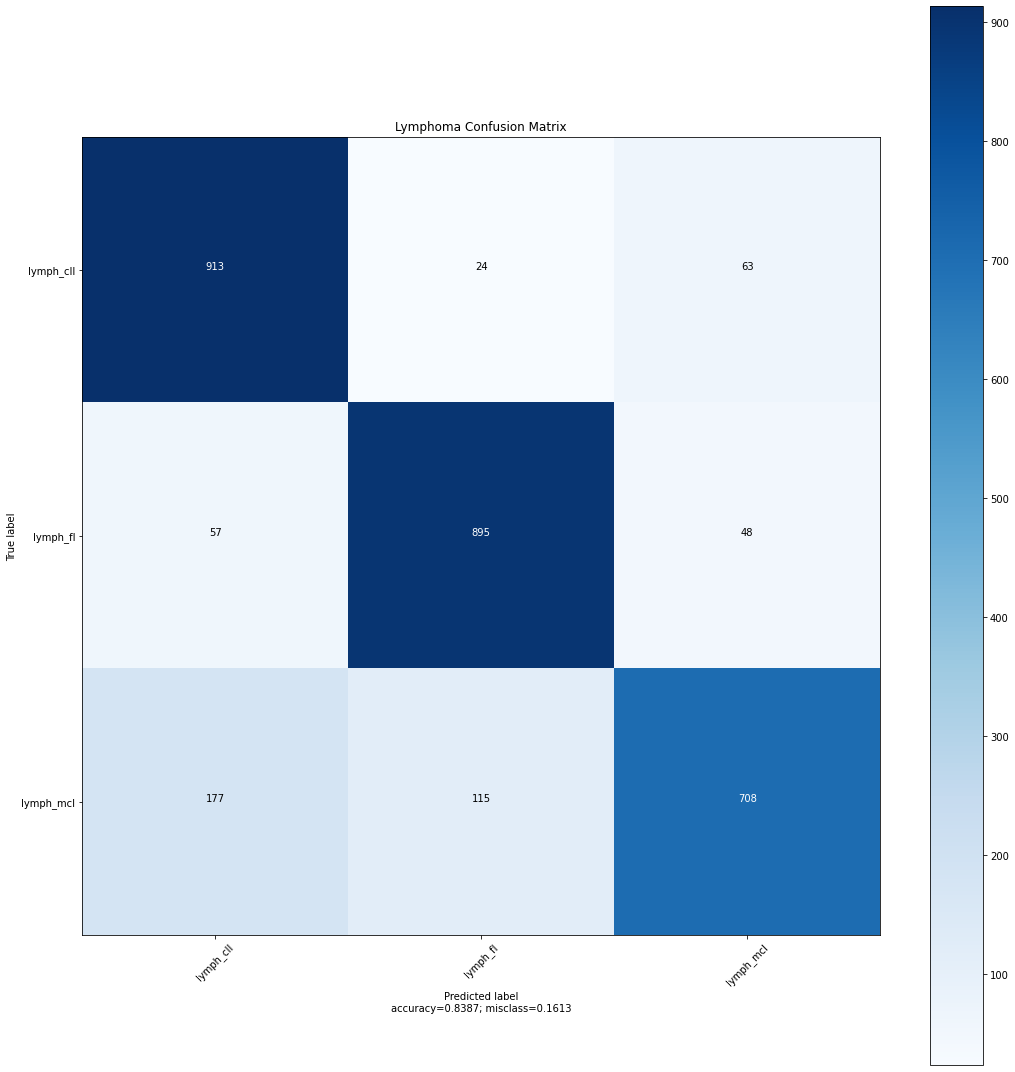

<Figure size 432x288 with 0 Axes>

In [53]:
# Train the model
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize = 256)

# Plot training history
plotOutput(curHistory, className, gEpochs)

# Evaluate the model
evalModel(curModel)

# Save the model
saveModel(curModel, className)

# Plot the confusion matrix
callPlot(curModel, className, class_names)

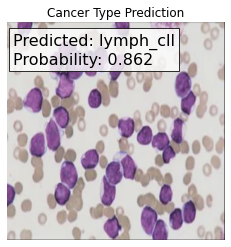

Predicted Cancer Type: lymph_cll


In [54]:
# Load the trained model
model = tf.keras.models.load_model(className+" - MobileNetV3.h5")

# Provide the path to the input image
input_image_path = "/kaggle/input/cancer-test-dataset/Screenshot 2023-06-16 at 12.04.09AM.png"
predicted_cancer_type = predict_cancer_type(input_image_path)

# Print the predicted cancer type
print("Predicted Cancer Type:", predicted_cancer_type)

*************

# Oral Cancer


Total :  Found 10002 files belonging to 2 classes.

For Training :  Found 8002 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['oral_normal', 'oral_scc']
Image Shape :  (32, 256, 256, 3)
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_7 (Rescaling)         (None, 224, 224, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_7[0][0]                
_________________________________

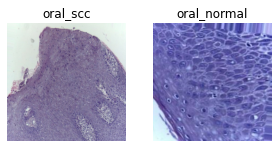

In [55]:
className='Oral Cancer'

cpath = os.path.join(mpath, className)

# Initiate the generator
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)

# Initiate the model
curModel = initiateModel(noOfClasses)

# Print the model summary
modelSummary(curModel)

# Initiate model parameters and callbacks
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)

Epoch 1/10
251/251 [==============================] - 119s 463ms/step - loss: 0.4645 - accuracy: 0.7722 - val_loss: 0.3927 - val_accuracy: 0.8320

Epoch 00001: val_loss improved from inf to 0.39268, saving model to Oral CancerMobileNet.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
251/251 [==============================] - 62s 247ms/step - loss: 0.3445 - accuracy: 0.8507 - val_loss: 0.3786 - val_accuracy: 0.8375

Epoch 00002: val_loss improved from 0.39268 to 0.37861, saving model to Oral CancerMobileNet.h5
Epoch 3/10
251/251 [==============================] - 62s 248ms/step - loss: 0.3123 - accuracy: 0.8689 - val_loss: 0.3369 - val_accuracy: 0.8550

Epoch 00003: val_loss improved from 0.37861 to 0.33693, saving model to Oral CancerMobileNet.h5
Epoch 4/10
251/251 [==============================] - 62s 248ms/step - loss: 0.2903 - accuracy: 0.8814 - val_loss: 0.3425 - val_accuracy: 0.8415

Epoch 00004: val_loss did not improve from 0.33693
Epoch 5/10
251/251 [==============================] - 62s 248ms/step - loss: 0.2735 - accuracy: 0.8882 - val_loss: 0.3185 - val_accuracy: 0.8590

Epoch 00005: val_loss improved from 0.33693 to 0.31851, saving model to Oral CancerMobileNet.h5
Epoch 6/10
251/251 [==============================] - 62s 247ms/step - loss: 

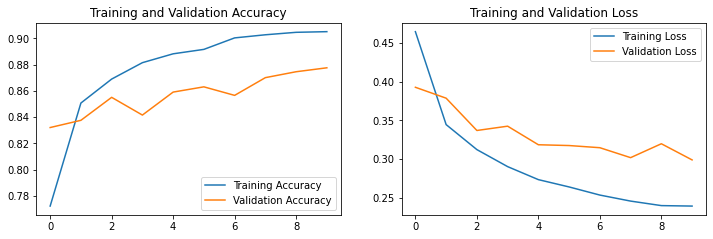

63/63 [==============================] - 12s 195ms/step - loss: 0.2990 - accuracy: 0.8775
Accuracy on the Test Set = 87.75 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

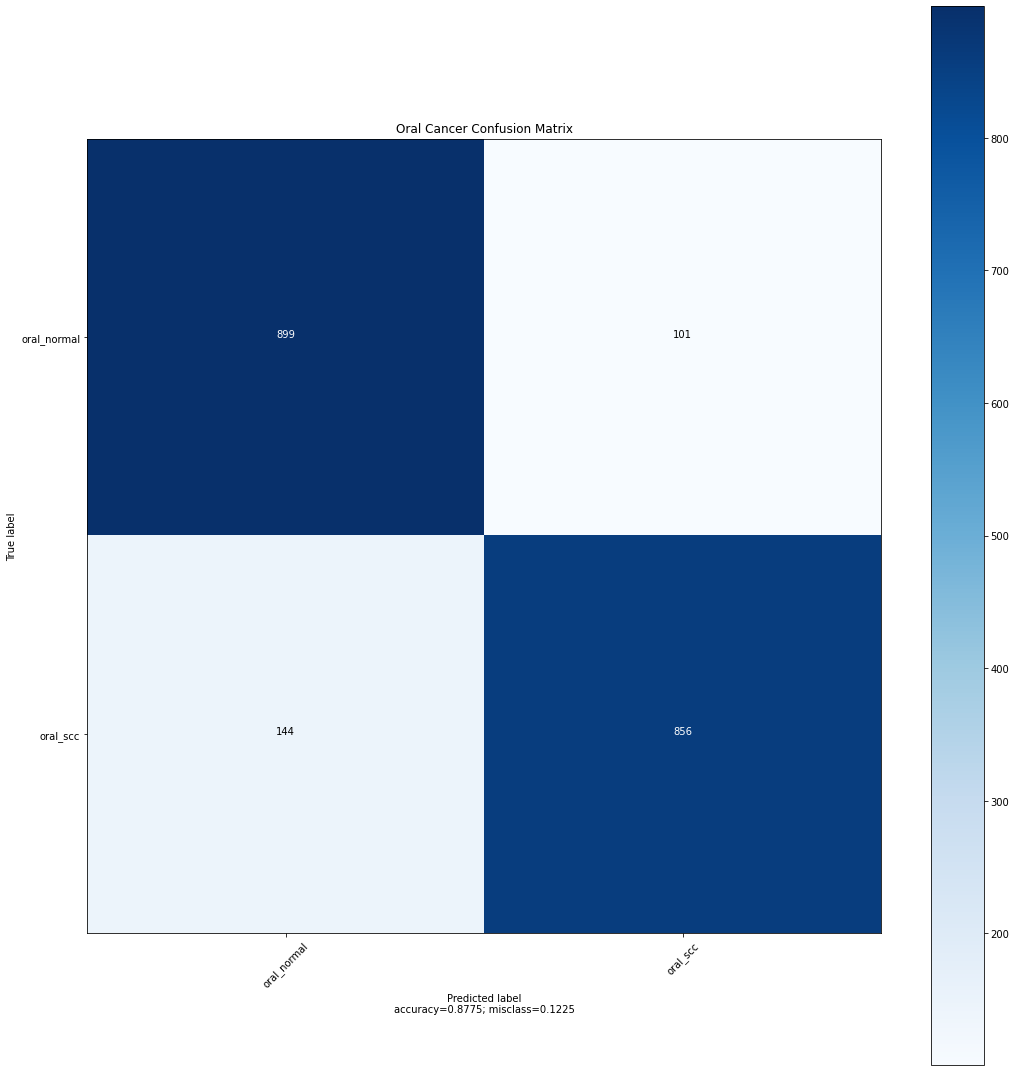

<Figure size 432x288 with 0 Axes>

In [56]:
# Train the model
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize = 256)

# Plot training history
plotOutput(curHistory, className, gEpochs)

# Evaluate the model
evalModel(curModel)

# Save the model
saveModel(curModel, className)

# Plot the confusion matrix
callPlot(curModel, className, class_names)

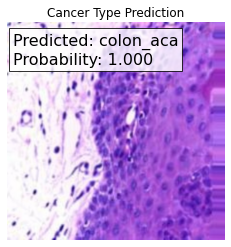

Predicted Cancer Type: colon_aca


In [31]:
# Load the trained model
model = tf.keras.models.load_model(className+" - MobileNetV3.h5")

# Provide the path to the input image
input_image_path = "/kaggle/input/multi-cancer/Multi Cancer/Oral Cancer/oral_normal/oral_normal_0002.jpg"
predicted_cancer_type = predict_cancer_type(input_image_path)

# Print the predicted cancer type
print("Predicted Cancer Type:", predicted_cancer_type)

In [ ]:
- MobileNetV3.h